## Import Data

In [6]:
import os
dataset_path = r'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom'
file_list = os.listdir(dataset_path)
print(file_list)

['butterfly', 'cat', 'cow', 'dog', 'elephant', 'horse', 'lizard', 'sheep', 'spider', 'squirrel']


In [7]:
#%pip install --upgrade tensorflow
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


## Import Functions

In [8]:
#Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from PIL import Image

#Import visualization libraries
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

#Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU

#System libraries
from pathlib import Path
import os.path
import requests
import time

#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

sns.set_style('darkgrid')

In [9]:
#Seeding to keep the images the same for multiple runs
def seed_everything(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)

seed_everything()

In [10]:
#URL of the helper function just to walk through directory
url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'
response = requests.get(url)
with open('helper_functions.py', 'wb') as file:
    file.write(response.content)

from helper_functions import walk_through_dir

In [11]:
#Batch size used, target size of the images
BATCH_SIZE = 16
TARGET_SIZE = (224, 224)

In [12]:
#Walking thorugh dataset to see the amount of images
dataset = dataset_path
walk_through_dir(dataset)

There are 10 directories and 0 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom'.
There are 0 directories and 6157 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\butterfly'.
There are 0 directories and 14144 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\cat'.
There are 0 directories and 5340 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\cow'.
There are 0 directories and 17333 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\dog'.
There are 0 directories and 5198 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\elephant'.
There are 0 directories and 5756 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\horse'.
There are 0 directories and 5157 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\lizard'.
There are 0 directories and 5033 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\shee

In [13]:
#Making a df
def convert_path_to_df(dataset):
    image_dir = Path(dataset)
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

C:\Users\Fathan Askar\AppData\Local\Temp\ipykernel_19148\2290020164.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, alpha=0.8, palette='pastel', ax=axes)


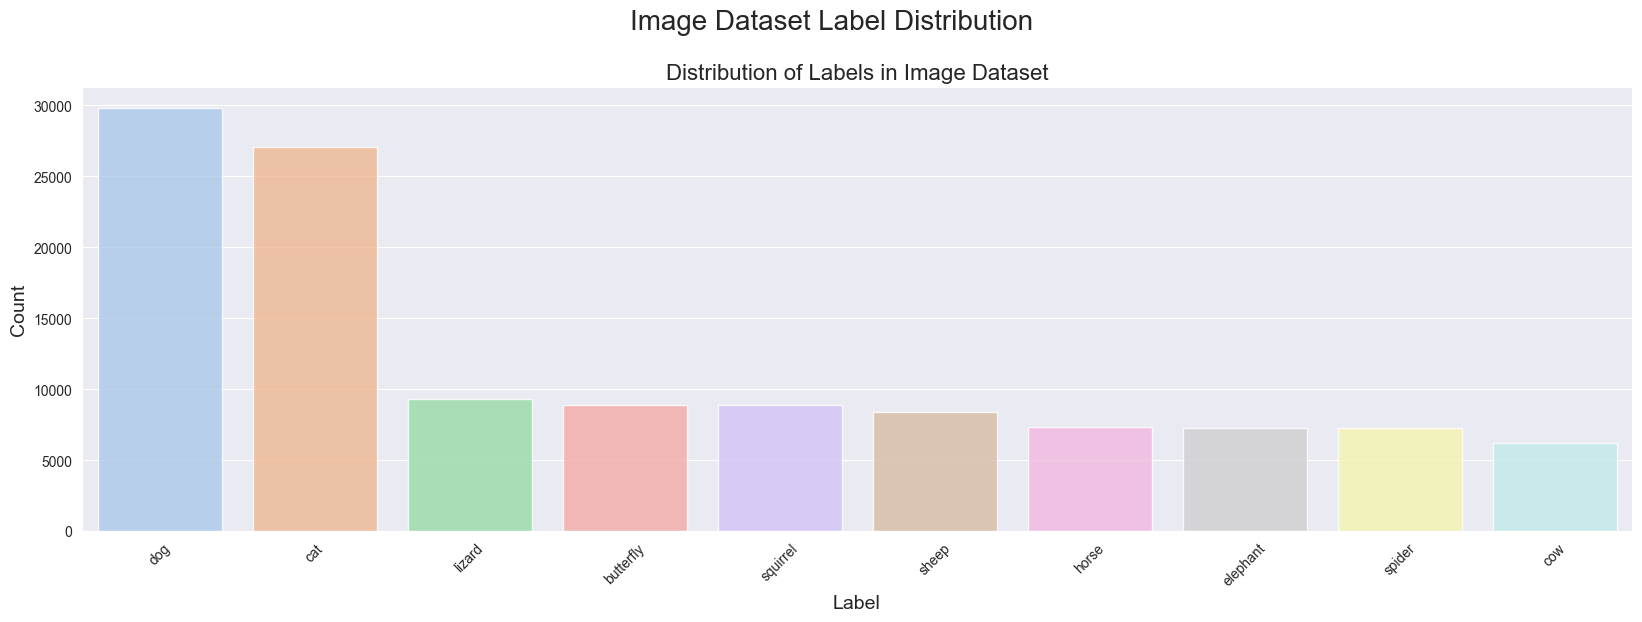

In [14]:
#Get the value counts for each label
label_counts = image_df['Label'].value_counts()

#Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

#Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)

#Set x-ticks and labels
axes.set_xticks(range(len(label_counts.index)))
axes.set_xticklabels(label_counts.index, rotation=45)
fig.suptitle('Image Dataset Label Distribution', fontsize=20)
fig.subplots_adjust(top=0.85)

plt.show()


C:\Users\Fathan Askar\AppData\Local\Temp\ipykernel_19148\766083734.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts_limited.index, y=label_counts_limited.values, hue=None, alpha=0.8, palette='pastel', ax=axes)


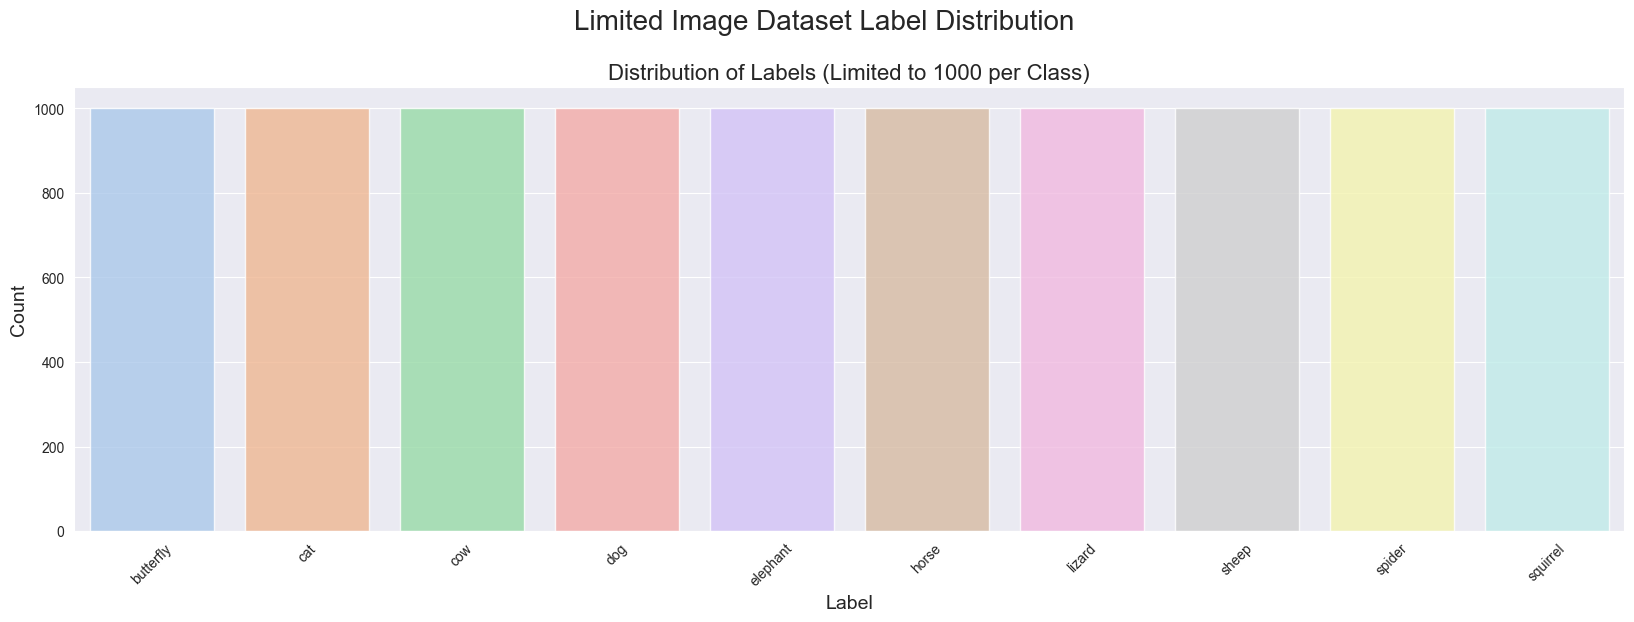

In [15]:
#Limit the number of images to 1000 per class
def limit_images_per_class(image_df, num_images=1000):
    image_df_limited = image_df.groupby('Label').apply(lambda x: x.sample(min(len(x), num_images), random_state=42)).reset_index(drop=True)
    return image_df_limited

#Create a df for the limited images per class
image_df_limited = limit_images_per_class(image_df, num_images=1000)
label_counts_limited = image_df_limited['Label'].value_counts()

#Plot the updated distribution
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
sns.barplot(x=label_counts_limited.index, y=label_counts_limited.values, hue=None, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels (Limited to 1000 per Class)', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticks(range(len(label_counts_limited.index)))
axes.set_xticklabels(label_counts_limited.index, rotation=45)
fig.suptitle('Limited Image Dataset Label Distribution', fontsize=20)
fig.subplots_adjust(top=0.85)

plt.show()


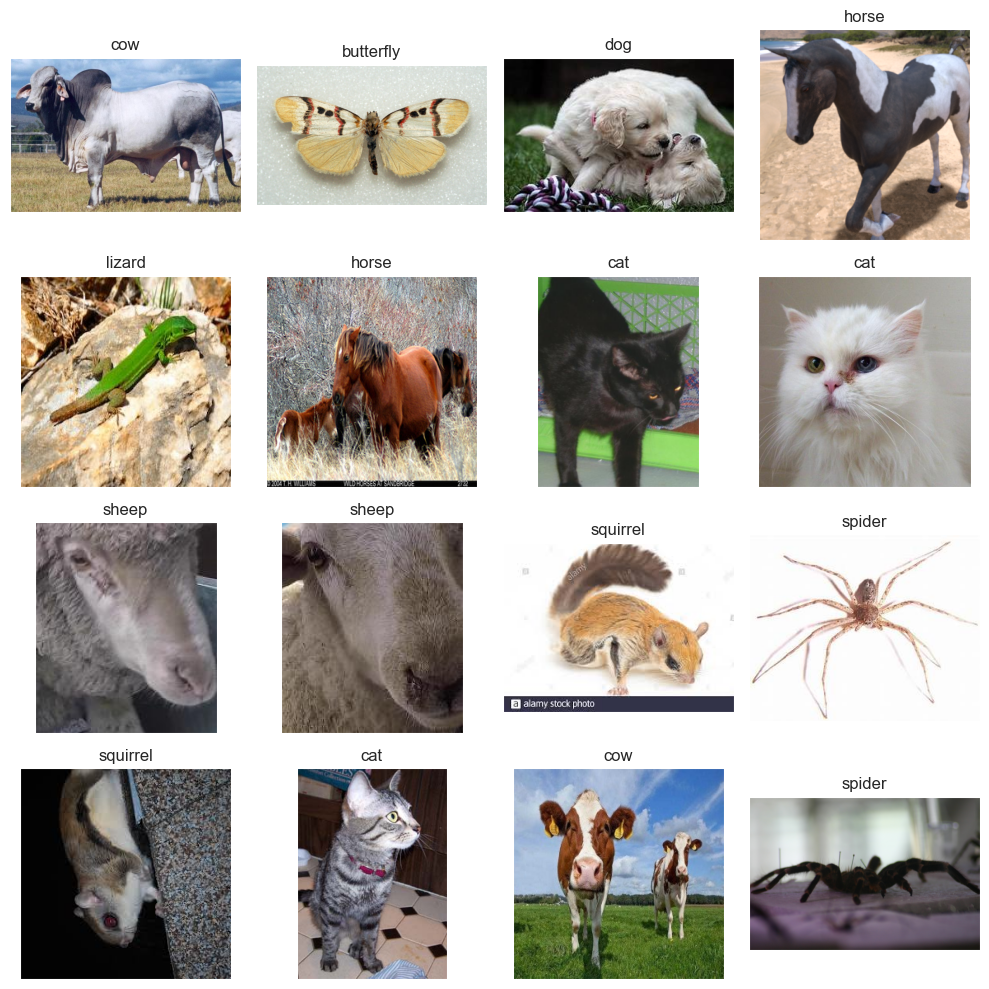

In [16]:
#Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Preprocessing Comparisons

In [17]:
#Preprocessing Functions
#Handling palette images
def convert_image_to_rgba(image):
    if isinstance(image, np.ndarray):
        return image
    else:
        with Image.open(image) as img:
            if img.mode == 'P':
                img = img.convert('RGBA')
            return np.array(img)

#Normalization
def normalize_image(image):
    image = convert_image_to_rgba(image)
    return image / 255.0
#Standardization
def standardize_image(image):
    image = convert_image_to_rgba(image)
    mean = np.mean(image, axis=(0, 1, 2), keepdims=True)
    std = np.std(image, axis=(0, 1, 2), keepdims=True)
    epsilon = 1e-7  #To avoid dividing by 0
    return (image - mean) / (std + epsilon)

#Enhancement
def enhance_image(image):
    image = convert_image_to_rgba(image)
    try:
        #Convert RGB image to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        #Split LAB image into its channels
        l, a, b = cv2.split(lab)
        #Ensure the L channel is in 8-bit unsigned integer format
        l = l.astype(np.uint8)
        #Apply CLAHE to the L channel (grayscale)
        clip_limit = np.var(l) / 255
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
        cl = clahe.apply(l)  # Apply CLAHE to L channel
        #Merge the CLAHE-enhanced L channel with the original A and B channels
        lab = cv2.merge((cl, a, b))
        #Convert LAB image back to RGB
        enhanced_image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        return enhanced_image
    #Because a lot of images have an error while processing enhancement, we return the normal image to the dataset so it doesnt keep stopping due to an error
    except Exception as e:
        return image 


#Noise Removal
def remove_noise(image):
    image = convert_image_to_rgba(image)
    #Reduce noise while preseerving edges
    bilateral_filter = cv2.bilateralFilter(image, 9, 75, 75)
    #Median Blur to the filter
    median_blur = cv2.medianBlur(bilateral_filter, 5)
    #Gaussian Blur to the median blur
    gaussian_blur = cv2.GaussianBlur(median_blur, (5, 5), 0)

    return gaussian_blur

In [18]:
#Separate dataset
train_df, test_df = train_test_split(image_df_limited, test_size=0.2, shuffle=True, random_state=42)


In [19]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Create train and validation generators from the training data
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,  #Resize images
    batch_size=16,
    class_mode='categorical',
    subset='training'  #training split
)

val_generator = datagen.flow_from_dataframe(
    train_df,  #Same dataframe as train, but for validation split
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    subset='validation'  #validation split
)


#Create the test generator separately
test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    shuffle=False 
)

Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


In [20]:
#CNN Model
model = models.Sequential([
    #Convolutional Block 1
    layers.Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    LeakyReLU(alpha=0.1), 
    layers.MaxPooling2D((2, 2)),

    #Convolutional Block 2
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    LeakyReLU(alpha=0.1), 
    layers.MaxPooling2D((2, 2)),

    #Convolutional Block 3
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    LeakyReLU(alpha=0.1),  
    layers.MaxPooling2D((2, 2)),

    #Global Average Pooling
    layers.GlobalAveragePooling2D(),

    #Fully Connected Layer with Dropout
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),  
    layers.Dropout(0.5),

    #Output Layer
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

#Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Model Summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 128)    5

### No Preprocessing

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[reduce_lr]
)


test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

import json
#Convert the history object to a JSON-serializable format because it couldn't handle float32
history_serializable = {key: [float(val) for val in values] for key, values in history.history.items()}

#Save the history to a JSON file to plot to a graph later
with open('history_noPreprocessing.json', 'w') as f:
    json.dump(history_serializable, f)



Epoch 1/20
 34/400 [=>............................] - ETA: 59s - loss: 2.8513 - accuracy: 0.1305

c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


400/400 [==============================] - 77s 174ms/step - loss: 2.5359 - accuracy: 0.1820 - val_loss: 2.6283 - val_accuracy: 0.1663 - lr: 0.0010
Epoch 2/20
400/400 [==============================] - 71s 177ms/step - loss: 2.2784 - accuracy: 0.2441 - val_loss: 2.1767 - val_accuracy: 0.2756 - lr: 0.0010
Epoch 3/20
400/400 [==============================] - 71s 177ms/step - loss: 2.1434 - accuracy: 0.2764 - val_loss: 2.4241 - val_accuracy: 0.1844 - lr: 0.0010
Epoch 4/20
400/400 [==============================] - 72s 180ms/step - loss: 2.0627 - accuracy: 0.2997 - val_loss: 2.0371 - val_accuracy: 0.2912 - lr: 0.0010
Epoch 5/20
400/400 [==============================] - 72s 181ms/step - loss: 1.9803 - accuracy: 0.3159 - val_loss: 1.9103 - val_accuracy: 0.3525 - lr: 0.0010
Epoch 6/20
400/400 [==============================] - 73s 182ms/step - loss: 1.9210 - accuracy: 0.3413 - val_loss: 1.9011 - val_accuracy: 0.3425 - lr: 0.0010
Epoch 7/20
400/400 [==============================] - 72s 181ms

### Normalization

In [22]:
#Apply Normalization using ImageDataGenerator
datagen_normalized = ImageDataGenerator(preprocessing_function=normalize_image, validation_split=0.2)

#Create train
train_generator_normalized = datagen_normalized.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

#Create validation
val_generator_normalized = datagen_normalized.flow_from_dataframe(
    train_df,  
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    subset='validation' 
)

#Test generator
test_generator_normalized = datagen_normalized.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


#Train and evaluate the model for normalization
history_normalized = model.fit(
    train_generator_normalized,
    validation_data=val_generator_normalized,
    epochs=20,
    callbacks=[reduce_lr]
)

test_loss_normalized, test_accuracy_normalized = model.evaluate(test_generator_normalized)
print(f"Test accuracy (normalized): {test_accuracy_normalized * 100:.2f}%")
history_serializable = {key: [float(val) for val in values] for key, values in history_normalized.history.items()}
with open('history_normalized.json', 'w') as f:
    json.dump(history_serializable, f)


Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.
Epoch 1/20
108/400 [=======>......................] - ETA: 49s - loss: 1.3837 - accuracy: 0.5376

c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


400/400 [==============================] - 73s 182ms/step - loss: 1.3677 - accuracy: 0.5441 - val_loss: 1.4451 - val_accuracy: 0.5088 - lr: 2.5000e-04
Epoch 2/20
400/400 [==============================] - 73s 183ms/step - loss: 1.3495 - accuracy: 0.5495 - val_loss: 1.3745 - val_accuracy: 0.5381 - lr: 2.5000e-04
Epoch 3/20
400/400 [==============================] - 74s 184ms/step - loss: 1.3295 - accuracy: 0.5536 - val_loss: 1.3421 - val_accuracy: 0.5481 - lr: 2.5000e-04
Epoch 4/20
400/400 [==============================] - 73s 183ms/step - loss: 1.3040 - accuracy: 0.5652 - val_loss: 1.5657 - val_accuracy: 0.4744 - lr: 2.5000e-04
Epoch 5/20
400/400 [==============================] - 73s 181ms/step - loss: 1.3038 - accuracy: 0.5631 - val_loss: 1.3815 - val_accuracy: 0.5531 - lr: 2.5000e-04
Epoch 6/20
400/400 [==============================] - 72s 181ms/step - loss: 1.2941 - accuracy: 0.5689 - val_loss: 1.3288 - val_accuracy: 0.5550 - lr: 2.5000e-04
Epoch 7/20
400/400 [===================

### Standardization

In [23]:
#Standardization
datagen_standardized = ImageDataGenerator(preprocessing_function=standardize_image, validation_split=0.2)

#Create train
train_generator_standardized = datagen_standardized.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    subset='training'  # For training data
)

#Create validation
val_generator_standardized = datagen_standardized.flow_from_dataframe(
    train_df, 
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    subset='validation' 
)

#Test generator
test_generator_standardized = datagen_standardized.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


history_standardized = model.fit(
    train_generator_standardized,
    validation_data=val_generator_standardized,
    epochs=20,
    callbacks=[reduce_lr]
)

test_loss_standardized, test_accuracy_standardized = model.evaluate(test_generator_standardized)
print(f"Test accuracy (standardized): {test_accuracy_standardized * 100:.2f}%")
history_serializable = {key: [float(val) for val in values] for key, values in history_standardized.history.items()}
with open('history_standardized.json', 'w') as f:
    json.dump(history_serializable, f)

Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.
Epoch 1/20
120/400 [========>.....................] - ETA: 46s - loss: 1.2415 - accuracy: 0.5870

c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


400/400 [==============================] - 72s 180ms/step - loss: 1.2261 - accuracy: 0.5994 - val_loss: 1.1745 - val_accuracy: 0.6256 - lr: 6.2500e-05
Epoch 2/20
400/400 [==============================] - 72s 180ms/step - loss: 1.2177 - accuracy: 0.5931 - val_loss: 1.1925 - val_accuracy: 0.6106 - lr: 6.2500e-05
Epoch 3/20
400/400 [==============================] - 72s 180ms/step - loss: 1.1957 - accuracy: 0.6103 - val_loss: 1.1729 - val_accuracy: 0.6263 - lr: 6.2500e-05
Epoch 4/20
400/400 [==============================] - 72s 180ms/step - loss: 1.1875 - accuracy: 0.6136 - val_loss: 1.1619 - val_accuracy: 0.6331 - lr: 6.2500e-05
Epoch 5/20
400/400 [==============================] - 73s 181ms/step - loss: 1.1754 - accuracy: 0.6195 - val_loss: 1.1572 - val_accuracy: 0.6325 - lr: 6.2500e-05
Epoch 6/20
400/400 [==============================] - 72s 181ms/step - loss: 1.1712 - accuracy: 0.6195 - val_loss: 1.1548 - val_accuracy: 0.6331 - lr: 6.2500e-05
Epoch 7/20
400/400 [===================

### Image Enhancement

In [24]:
#Image Enhancement
datagen_enhanced = ImageDataGenerator(preprocessing_function=enhance_image, validation_split=0.2)

# Create train
train_generator_enhanced = datagen_enhanced.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

#Create validation
val_generator_enhanced = datagen_enhanced.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

#Test generator
test_generator_enhanced = datagen_enhanced.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

history_enhanced = model.fit(
    train_generator_enhanced,
    validation_data=val_generator_enhanced,
    epochs=20,
    callbacks=[reduce_lr]
)

#Evaluate the model
test_loss_enhanced, test_accuracy_enhanced = model.evaluate(test_generator_enhanced)
print(f"Test accuracy (enhanced): {test_accuracy_enhanced * 100:.2f}%")
history_serializable = {key: [float(val) for val in values] for key, values in history_enhanced.history.items()}
with open('history_enhanced.json', 'w') as f:
    json.dump(history_serializable, f)


Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.
Epoch 1/20
 66/400 [===>..........................] - ETA: 57s - loss: 1.1280 - accuracy: 0.6212

c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


400/400 [==============================] - 76s 189ms/step - loss: 1.1358 - accuracy: 0.6259 - val_loss: 1.1334 - val_accuracy: 0.6237 - lr: 7.8125e-06
Epoch 2/20
400/400 [==============================] - 75s 188ms/step - loss: 1.1097 - accuracy: 0.6373 - val_loss: 1.1026 - val_accuracy: 0.6381 - lr: 7.8125e-06
Epoch 3/20
400/400 [==============================] - 75s 188ms/step - loss: 1.0978 - accuracy: 0.6373 - val_loss: 1.0988 - val_accuracy: 0.6388 - lr: 7.8125e-06
Epoch 4/20
400/400 [==============================] - 75s 188ms/step - loss: 1.1055 - accuracy: 0.6442 - val_loss: 1.0913 - val_accuracy: 0.6444 - lr: 7.8125e-06
Epoch 5/20
400/400 [==============================] - 75s 188ms/step - loss: 1.0979 - accuracy: 0.6370 - val_loss: 1.0965 - val_accuracy: 0.6481 - lr: 7.8125e-06
Epoch 6/20
400/400 [==============================] - 76s 190ms/step - loss: 1.0921 - accuracy: 0.6375 - val_loss: 1.0903 - val_accuracy: 0.6481 - lr: 7.8125e-06
Epoch 7/20
400/400 [===================

### Noise Removal

In [25]:
#Noise removal
datagen_denoised = ImageDataGenerator(preprocessing_function=remove_noise, validation_split=0.2)

#Create train
train_generator_denoised = datagen_denoised.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

#Create validation
val_generator_denoised = datagen_denoised.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

#Test generator
test_generator_denoised = datagen_denoised.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

history_denoised = model.fit(
    train_generator_denoised,
    validation_data=val_generator_denoised,
    epochs=20,
    callbacks=[reduce_lr]
)

test_loss_denoised, test_accuracy_denoised = model.evaluate(test_generator_denoised)
print(f"Test accuracy (denoised): {test_accuracy_denoised * 100:.2f}%")
history_serializable = {key: [float(val) for val in values] for key, values in history_denoised.history.items()}
with open('history_denoised.json', 'w') as f:
    json.dump(history_serializable, f)

Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.
Epoch 1/20
 43/400 [==>...........................] - ETA: 1:01 - loss: 1.7128 - accuracy: 0.4172

c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


400/400 [==============================] - 78s 195ms/step - loss: 1.6611 - accuracy: 0.4427 - val_loss: 1.5901 - val_accuracy: 0.4625 - lr: 1.9531e-06
Epoch 2/20
400/400 [==============================] - 80s 200ms/step - loss: 1.5958 - accuracy: 0.4584 - val_loss: 1.5569 - val_accuracy: 0.4719 - lr: 1.9531e-06
Epoch 3/20
400/400 [==============================] - 78s 196ms/step - loss: 1.5722 - accuracy: 0.4728 - val_loss: 1.5384 - val_accuracy: 0.4806 - lr: 1.9531e-06
Epoch 4/20
400/400 [==============================] - 78s 195ms/step - loss: 1.5537 - accuracy: 0.4753 - val_loss: 1.5282 - val_accuracy: 0.4881 - lr: 1.9531e-06
Epoch 5/20
400/400 [==============================] - 78s 196ms/step - loss: 1.5571 - accuracy: 0.4812 - val_loss: 1.5191 - val_accuracy: 0.4925 - lr: 1.9531e-06
Epoch 6/20
400/400 [==============================] - 78s 195ms/step - loss: 1.5418 - accuracy: 0.4859 - val_loss: 1.5111 - val_accuracy: 0.4969 - lr: 1.9531e-06
Epoch 7/20
400/400 [===================

### Comparisons

In [26]:
import json
import matplotlib.pyplot as plt

def load_history_from_json(json_file):
    with open(json_file, 'r') as f:
        return json.load(f)

#Load each json history
history_noPreprocessing = load_history_from_json('history_noPreprocessing.json')
history_normalized = load_history_from_json('history_normalized.json')
history_standardized = load_history_from_json('history_standardized.json')
history_enhanced = load_history_from_json('history_enhanced.json')
history_denoised = load_history_from_json('history_denoised.json')


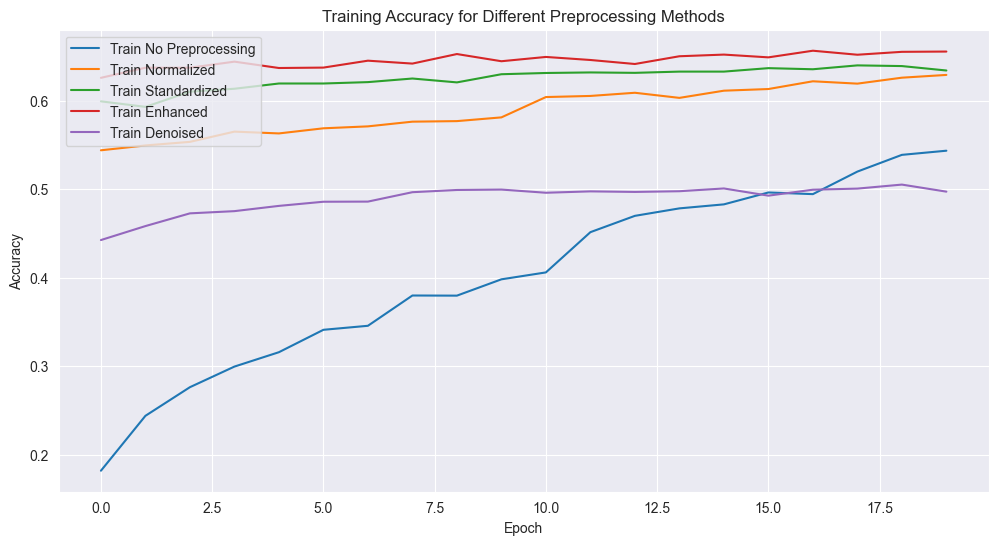

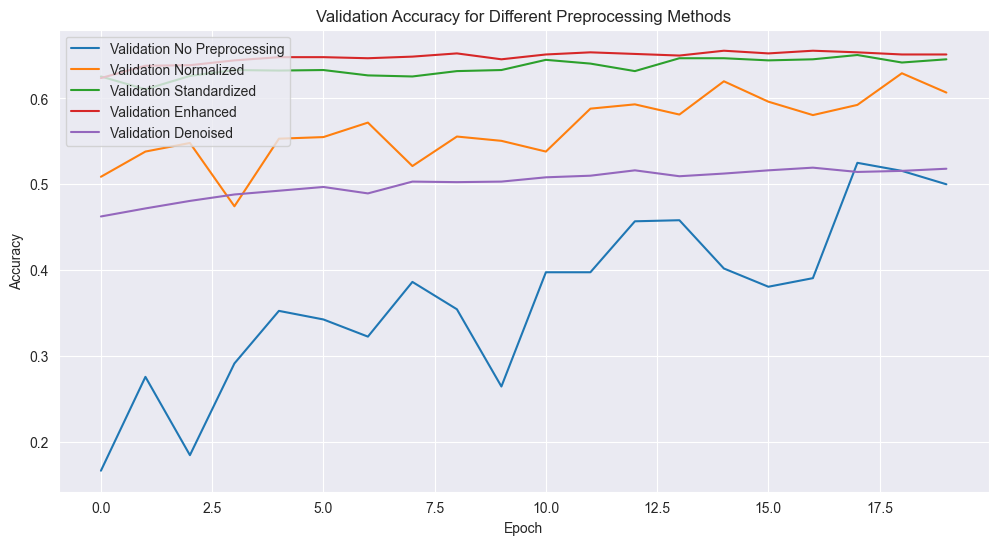

In [27]:
def plot_train_and_validation_histories(histories, labels, metric='accuracy'):
    #Plot Training Accuracy
    plt.figure(figsize=(12, 6))
    for history, label in zip(histories, labels):
        plt.plot(history[metric], label=f'Train {label}')
    plt.title('Training Accuracy for Different Preprocessing Methods')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    #Plot Validation Accuracy
    plt.figure(figsize=(12, 6))
    for history, label in zip(histories, labels):
        plt.plot(history[f'val_{metric}'], label=f'Validation {label}')
    plt.title('Validation Accuracy for Different Preprocessing Methods')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

#Create a list of the loaded histories
histories = [history_noPreprocessing, history_normalized, history_standardized, history_enhanced, history_denoised]
labels = ['No Preprocessing', 'Normalized', 'Standardized', 'Enhanced', 'Denoised']

#Plot the accuracy for each method
plot_train_and_validation_histories(histories, labels, metric='accuracy')


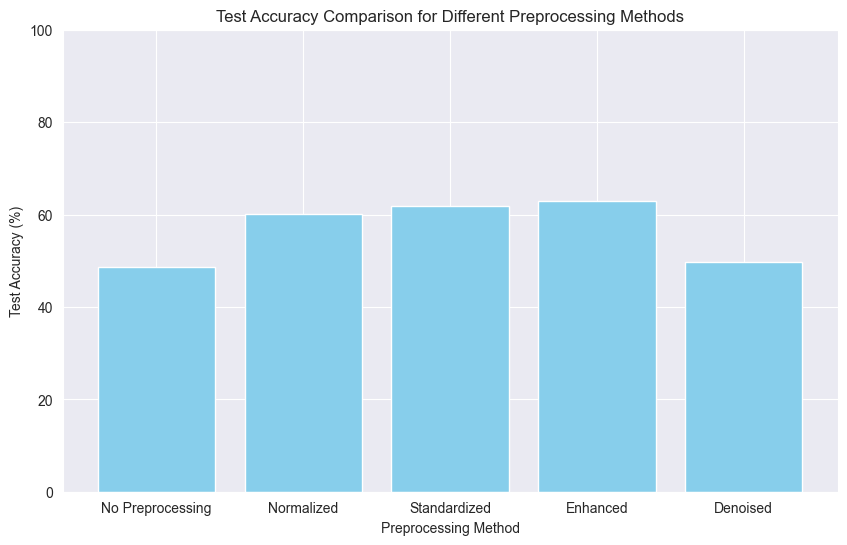

In [28]:
#Collect test accuracy for each method
accuracies = {
    'No Preprocessing': test_accuracy * 100,
    'Normalized': test_accuracy_normalized * 100,
    'Standardized': test_accuracy_standardized * 100,
    'Enhanced': test_accuracy_enhanced * 100,
    'Denoised': test_accuracy_denoised * 100,
}

plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.title('Test Accuracy Comparison for Different Preprocessing Methods')
plt.xlabel('Preprocessing Method')
plt.ylabel('Test Accuracy (%)')
plt.ylim([0, 100])
plt.show()


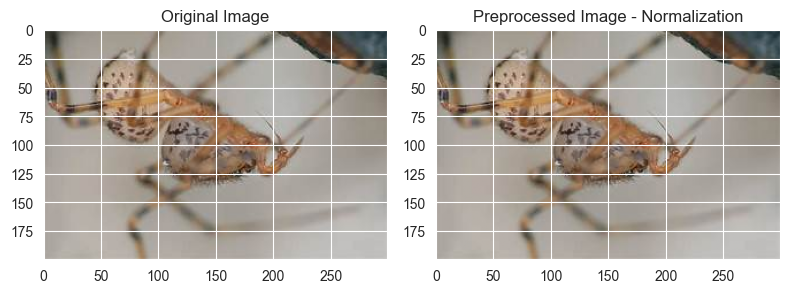

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.486876154829761..2.828210827638891].


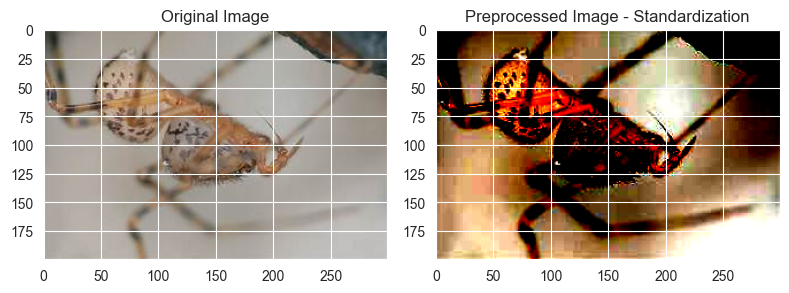

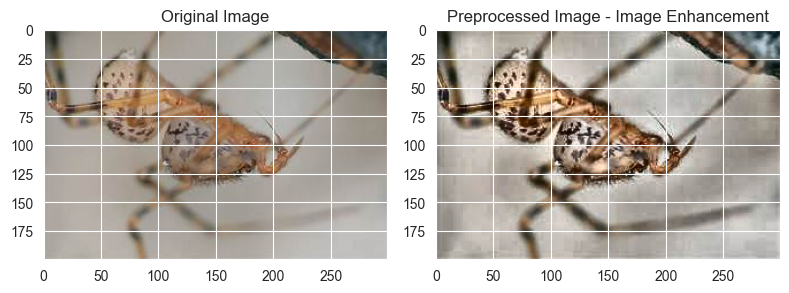

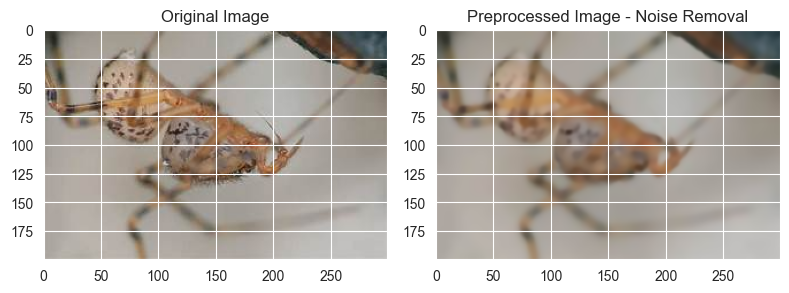

In [29]:
#Helper function to display original and preprocessed images
train_image_paths = train_df['Filepath'].tolist()
def visualize_preprocessing(image_path, preprocess_function, title):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    preprocessed_image = preprocess_function(original_image)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_image)
    plt.title(f'Preprocessed Image - {title}')

    plt.tight_layout()
    plt.show()

#Visualizing a random image from the dataset
sample_image_path = random.choice(train_image_paths)

#Visualize for each preprocessing method
visualize_preprocessing(sample_image_path, normalize_image, 'Normalization')
visualize_preprocessing(sample_image_path, standardize_image, 'Standardization')
visualize_preprocessing(sample_image_path, enhance_image, 'Image Enhancement')
visualize_preprocessing(sample_image_path, remove_noise, 'Noise Removal')

125/125 [==============================] - 12s 92ms/step


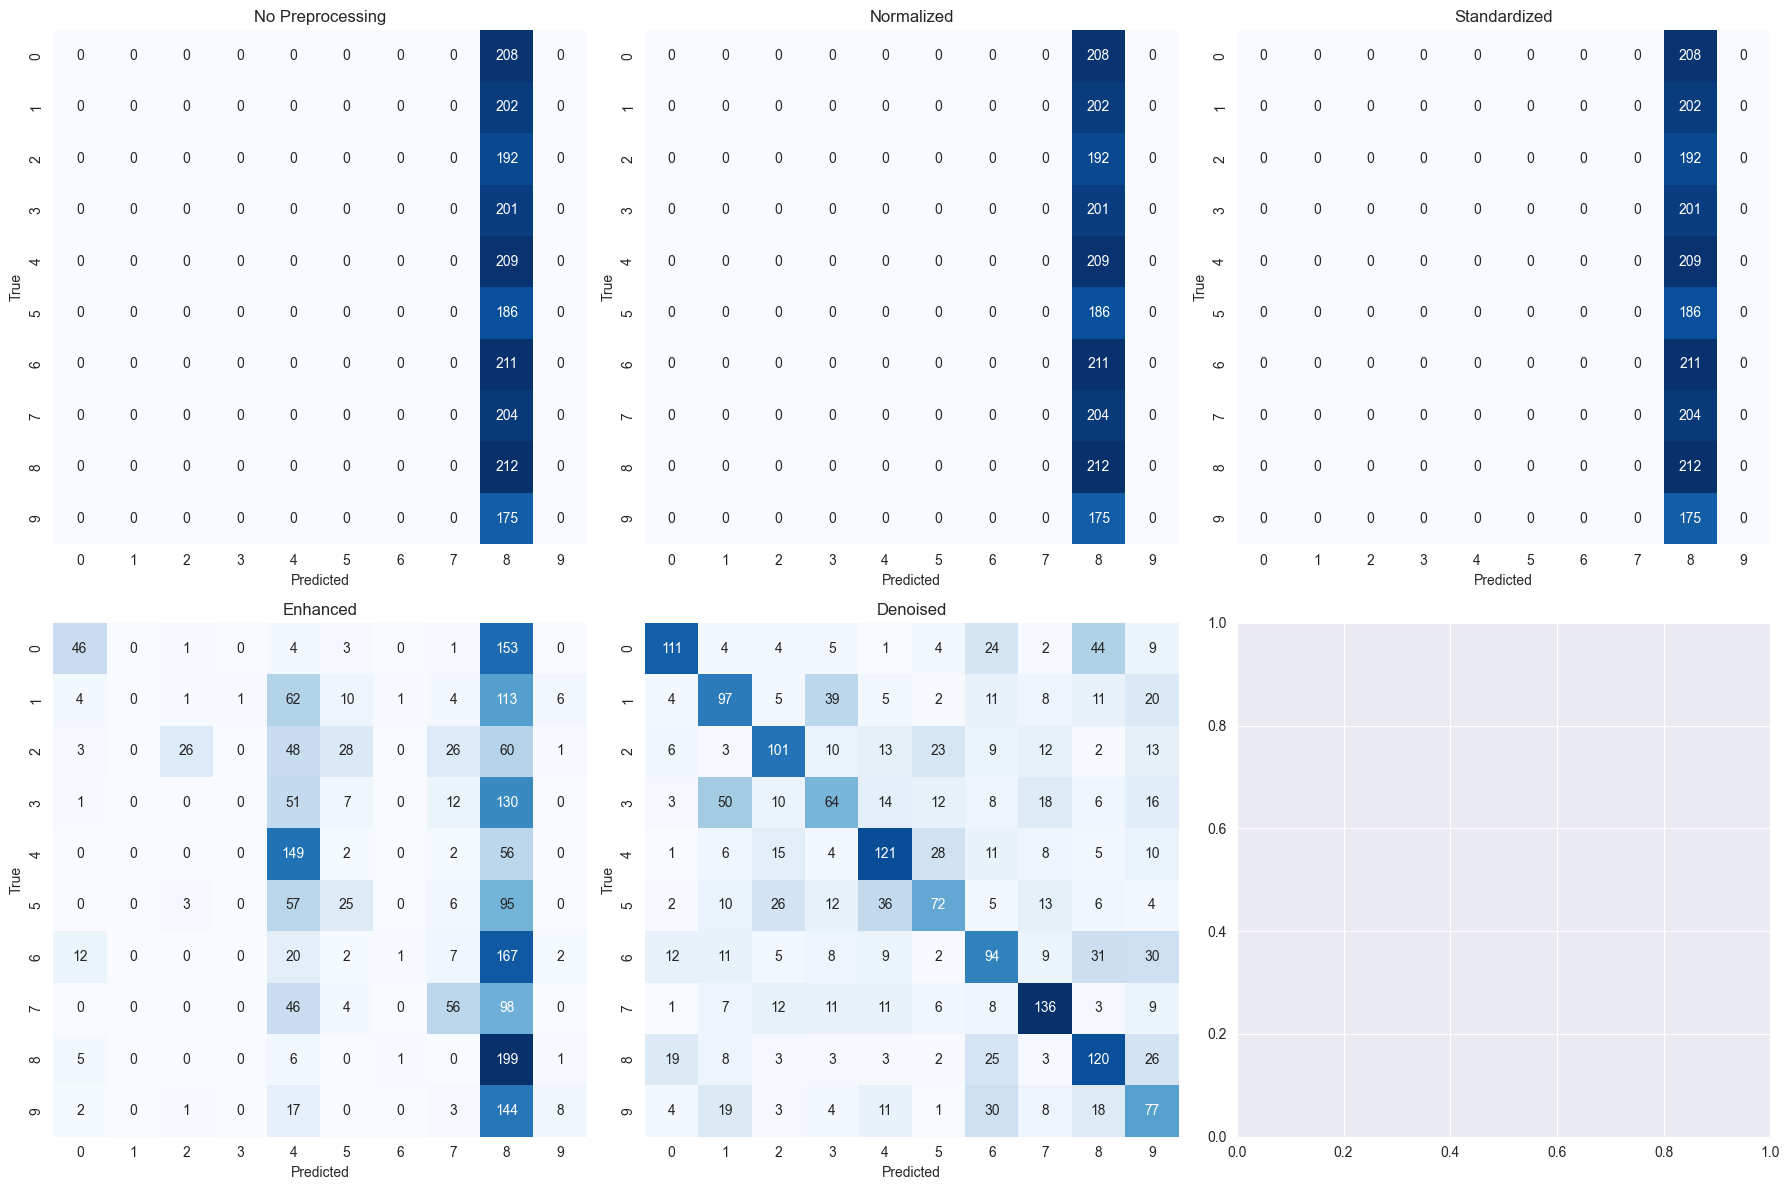

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels = test_generator.classes
predicted_labels_noPreprocessing = np.argmax(model.predict(test_generator), axis=1)
predicted_labels_normalized = np.argmax(model.predict(test_generator_normalized), axis=1)
predicted_labels_standardized = np.argmax(model.predict(test_generator_standardized), axis=1)
predicted_labels_enhanced = np.argmax(model.predict(test_generator_enhanced), axis=1)
predicted_labels_denoised = np.argmax(model.predict(test_generator_denoised), axis=1)

#Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

predictions = {
    'No Preprocessing': predicted_labels_noPreprocessing,
    'Normalized': predicted_labels_normalized,
    'Standardized': predicted_labels_standardized,
    'Enhanced': predicted_labels_enhanced,
    'Denoised': predicted_labels_denoised,
}


# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
for i, (method, predicted_labels) in enumerate(predictions.items()):
    plot_confusion_matrix(true_labels, predicted_labels, method, ax=axes[i])

plt.tight_layout()
plt.show()
